In [1]:
import sys
import os

from astropy.constants.codata2018 import alpha

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '...', 'src')))

import numpy as np
import matplotlib.pyplot as plt
from src.data_handler import load_tles_from_url, get_initial_state_and_time
from src.orbital_mechanics import runge_kutta_4

print("Modules loaded successfully")

Modules loaded successfully


In [2]:
ts, satellites = load_tles_from_url()

if satellites:
    test_satellite = satellites[0]
    satellites_name = test_satellite.name
    print(f"\nSatellite: {satellites_name}")

    t0_skyfield, state_initial_km = get_initial_state_and_time(test_satellite,ts)

    print("\nInitial State:")
    print(f"Initial Time (Epoch): {t0_skyfield.utc_strftime()}")
    print(f"Initial Position (km): {state_initial_km[0:3]}")
    print(f"Initial Velocity (km/s): {state_initial_km[3:6]}")

    SIMULATION_DURATION_HOURS = 1
    DELTA_T_SECONDS = 60

    duration_seconds = SIMULATION_DURATION_HOURS * 3600
    num_steps = int(duration_seconds / DELTA_T_SECONDS)

    print(f"\nSimulation Parameters:")
    print(f"Total Duration: {SIMULATION_DURATION_HOURS} hours ({duration_seconds}s)")
    print(f"Time Steps (dt): {DELTA_T_SECONDS} seconds")
    print(f"Number Steps: {num_steps}")
else:
    print("It's not possible to continue the simulation without the TLEs data")



Successfully loaded 13247 satellites from CelesTrak.

Satellite: CALSPHERE 1

Initial State:
Tempo Inicial (Epoch): 2025-11-07 19:42:59 UTC
Initial Position (km): [-351.94827493 -913.76647258 7296.59618338]
Initial Velocity (km/s): [-2.9312576  -6.66654466 -0.9858667 ]

Simulation Parameters:
Total Duration: 1 hours (3600s)
Time Steps (dt): 60 seconds
Number Steps: 60


In [3]:
print("\nExecuting RK4...")
time_series_rk4, state_history_rk4 = runge_kutta_4(
    state_initial_km,DELTA_T_SECONDS,num_steps
)
print("RK4 concluded.")

print("Executing Skyfield for validation...")
r_skyfield_history = np.zeros((num_steps + 1, 3))
v_skyfield_history = np.zeros((num_steps + 1, 3))

t_skyfield_series = ts.tt_jd(t0_skyfield.tt + time_series_rk4 / (24 * 3600))

for i, t_skyfield in enumerate(t_skyfield_series):
    geocentric_position = test_satellite.at(t_skyfield)

    r_vector = geocentric_position.position.km
    v_vector = geocentric_position.velocity.km_per_s

    r_skyfield_history[i, :] = r_vector
    v_skyfield_history[i, :] = v_vector

print("Skyfield concluded.")


Executing RK4...
RK4 concluded.
Executing Skyfield for validation...
Skyfield concluded.


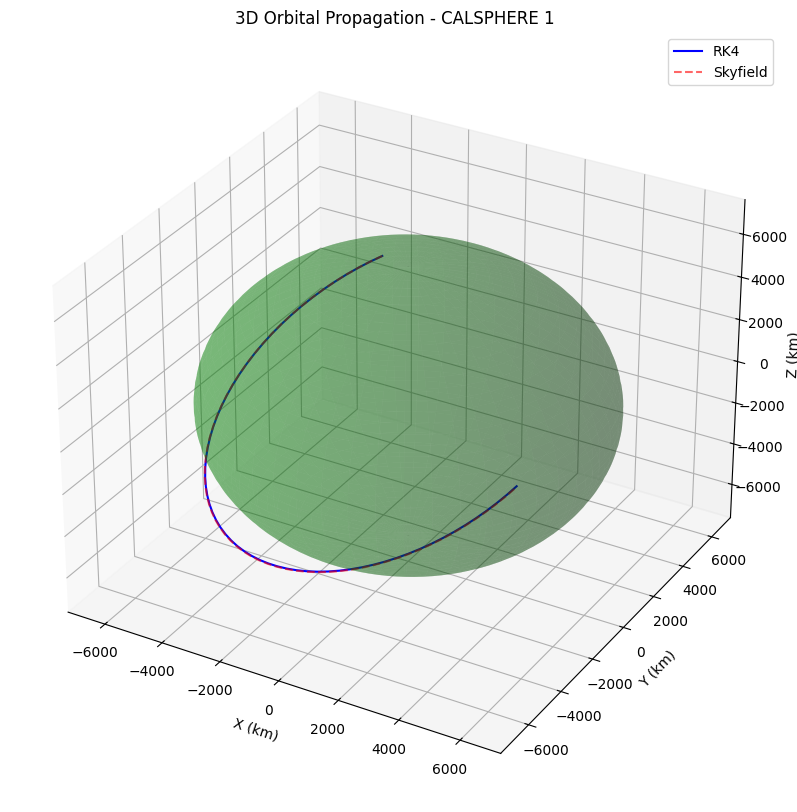


--- Validation ---
Simulation Duration: 1 hours
Final RK4 Position: [ 1654.86738353  3863.97388009 -6006.85163794]
Final Skyfield Position: [ 1630.90574975  3810.57433119 -6075.54118734]
Position Error (Magnitude Difference): 90.24 km


In [4]:
from src.constants import RADIUS_EARTH

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

#RK4 trajectory
ax.plot(state_history_rk4[:, 0], state_history_rk4[:, 1], state_history_rk4[:, 2],
        label='RK4', color='blue', linestyle='-')
#Skyfield trajectory
ax.plot(r_skyfield_history[:, 0], r_skyfield_history[:, 1], r_skyfield_history[:, 2],
        label='Skyfield', color='red', linestyle='--', alpha=0.6)

u = np.linspace(0,2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x_earth = RADIUS_EARTH * np.outer(np.cos(u), np.sin(v))
y_earth = RADIUS_EARTH * np.outer(np.sin(u), np.sin(v))
z_earth = RADIUS_EARTH * np.outer(np.ones(np.size(u)), np.cos(v))

ax.plot_surface(x_earth, y_earth, z_earth, color='green', alpha=0.3)

ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_zlabel('Z (km)')
ax.set_title(f'3D Orbital Propagation - {satellites_name}')
ax.legend()
plt.show()

final_r_skyfield = r_skyfield_history[-1, :]
final_r_rk4 = state_history_rk4[-1, 0:3]

difference_vector = final_r_rk4 - final_r_skyfield
error_magnitude =  np.linalg.norm(difference_vector)

print(f"\n--- Validation ---")
print(f"Simulation Duration: {SIMULATION_DURATION_HOURS} hours")
print(f"Final RK4 Position: {final_r_rk4}")
print(f"Final Skyfield Position: {final_r_skyfield}")
print(f"Position Error (Magnitude Difference): {error_magnitude:.2f} km")